In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/as22/fruits-360_dataset.zip /content
!unzip /content/fruits-360_dataset.zip


# Problem 1

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_path = '/content/fruits-360_dataset/fruits-360'
train_path = base_path + '/Training'
test_path = base_path + '/Test'



BATCH_SIZE = 1000
IMG_SIZE = (75, 75)
SEED = 42


In [4]:
train_gen, valid_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label


train_gen = train_gen.map(normalize_img)
valid_gen = valid_gen.map(normalize_img)
test_gen = test_gen.map(normalize_img)



train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 67692 files belonging to 131 classes.
Using 57539 files for training.
Using 10153 files for validation.
Found 22688 files belonging to 131 classes.


In [15]:
def create_model1(dropout_rate):
    weight_initializer = initializers.GlorotUniform(seed=99)
    bias_initializer = initializers.Zeros()

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.03),
    ])

    model = models.Sequential()

    model.add(data_augmentation)

    # First Conv layer
    model.add(layers.Conv2D(64, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer, input_shape=(75, 75, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv layer
    model.add(layers.Conv2D(128, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(256, activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.Dense(131, activation='softmax', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))

    return model


def create_model2(dropout_rate):
    weight_initializer = initializers.GlorotUniform(seed=99)
    bias_initializer = initializers.Zeros()

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.03),
    ])

    model = models.Sequential()

    model.add(data_augmentation)

    # First Conv layer
    model.add(layers.Conv2D(64, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer, input_shape=(75, 75, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv layer
    model.add(layers.Conv2D(128, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Conv layer
    model.add(layers.Conv2D(256, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    # Dense Layers
    model.add(layers.Dense(512, activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))
    model.add(layers.Dense(131, activation='softmax', kernel_initializer=weight_initializer, bias_initializer=bias_initializer))

    return model


def create_model_bonus(dropout_rate):
    weight_initializer = initializers.GlorotUniform(seed=99)
    bias_initializer = initializers.Zeros()

    inputs = layers.Input(shape=(75, 75, 3))

    x0 = layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
    x00 = tf.keras.layers.experimental.preprocessing.RandomRotation(0.03)(x0)

    # First Conv layer
    x1 = layers.Conv2D(128, (3,3), strides=(1,1), padding = 'same', activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(x00)
    x2 = layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x2_reduced = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x2)  # Reduce size for skip connection

    # Second Conv layer
    x3 = layers.Conv2D(128, (3,3), strides=(1,1), activation='relu', padding = 'same', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(x2)
    x4 = layers.MaxPooling2D(pool_size=(2, 2))(x3)

    # Concatenate for skip connection
    skip_connection = layers.concatenate([x4, x2_reduced])

    # Third Conv layer
    x5 = layers.Conv2D(256, (3,3), strides=(1,1), activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(skip_connection)
    x6 = layers.BatchNormalization(momentum=0.99, epsilon=0.001)(x5)
    x7 = layers.Dropout(dropout_rate)(x6)
    x8 = layers.MaxPooling2D(pool_size=(2, 2))(x7)

    flat = layers.Flatten()(x8)

    # Dense Layers
    dense1 = layers.Dense(512, activation='relu', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(flat)
    outputs = layers.Dense(131, activation='softmax', kernel_initializer=weight_initializer, bias_initializer=bias_initializer)(dense1)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model




Epoch 1/50
58/58 [==============================] - 11s 149ms/step - loss: 1.1291 - accuracy: 0.7610 - val_loss: 3.2948 - val_accuracy: 0.1986
Epoch 2/50
58/58 [==============================] - 8s 145ms/step - loss: 0.0204 - accuracy: 0.9949 - val_loss: 2.4104 - val_accuracy: 0.5909
Epoch 3/50
58/58 [==============================] - 8s 145ms/step - loss: 0.0106 - accuracy: 0.9975 - val_loss: 1.6288 - val_accuracy: 0.8716
Epoch 4/50
58/58 [==============================] - 8s 145ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.9133 - val_accuracy: 0.9650
Epoch 5/50
58/58 [==============================] - 8s 145ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.4806 - val_accuracy: 0.9731
Epoch 6/50
58/58 [==============================] - 8s 145ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.3673 - val_accuracy: 0.9444
Epoch 7/50
58/58 [==============================] - 8s 145ms/step - loss: 0.0526 - accuracy: 0.9886 - val_loss: 1.1421 - val_accuracy: 0.6480
Epoch

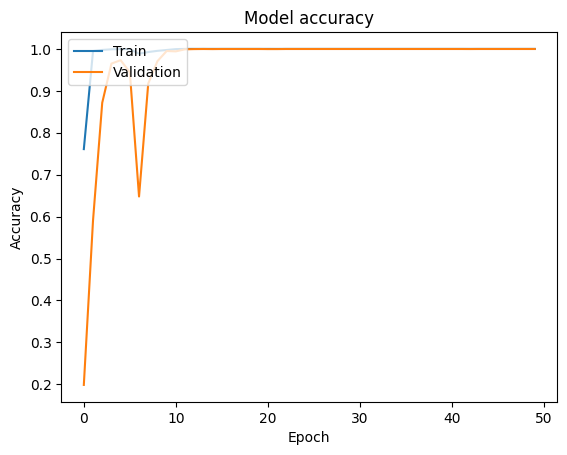

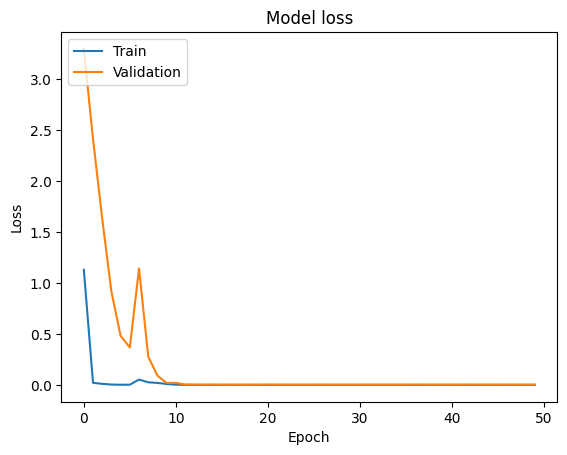

In [18]:
model1_1 = create_model1(0.1)

model1_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1_1.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model1_1.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/50
58/58 [==============================] - 11s 148ms/step - loss: 1.4580 - accuracy: 0.7071 - val_loss: 3.4564 - val_accuracy: 0.2126
Epoch 2/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0217 - accuracy: 0.9953 - val_loss: 2.6124 - val_accuracy: 0.4468
Epoch 3/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 1.9419 - val_accuracy: 0.6646
Epoch 4/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0087 - accuracy: 0.9979 - val_loss: 1.7475 - val_accuracy: 0.5793
Epoch 5/50
58/58 [==============================] - 8s 145ms/step - loss: 0.0156 - accuracy: 0.9965 - val_loss: 1.2123 - val_accuracy: 0.6623
Epoch 6/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0128 - accuracy: 0.9973 - val_loss: 1.1344 - val_accuracy: 0.6995
Epoch 7/50
58/58 [==============================] - 8s 145ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.8726 - val_accuracy: 0.7656
Epoch

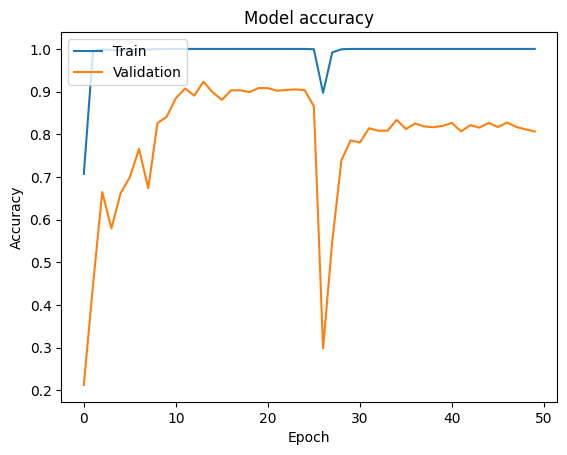

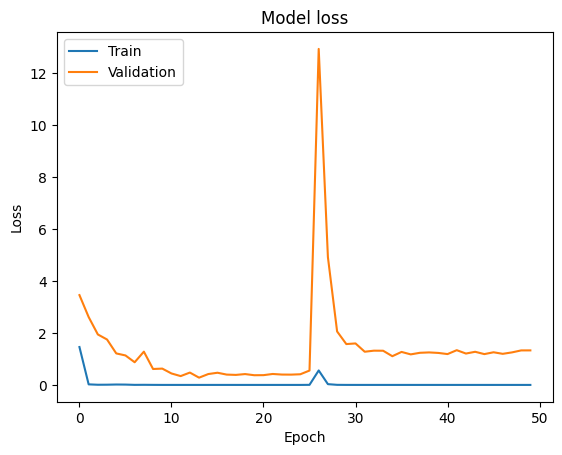

In [11]:
model1_3 = create_model1(0.3)

model1_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1_3.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model1_3.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/50
58/58 [==============================] - 11s 147ms/step - loss: 1.7284 - accuracy: 0.6581 - val_loss: 3.6081 - val_accuracy: 0.2420
Epoch 2/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0292 - accuracy: 0.9935 - val_loss: 2.9026 - val_accuracy: 0.5304
Epoch 3/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0134 - accuracy: 0.9974 - val_loss: 2.3350 - val_accuracy: 0.6450
Epoch 4/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0114 - accuracy: 0.9973 - val_loss: 1.8146 - val_accuracy: 0.6923
Epoch 5/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 1.3589 - val_accuracy: 0.7374
Epoch 6/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 1.1617 - val_accuracy: 0.7101
Epoch 7/50
58/58 [==============================] - 8s 146ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.6651 - val_accuracy: 0.8362
Epoch

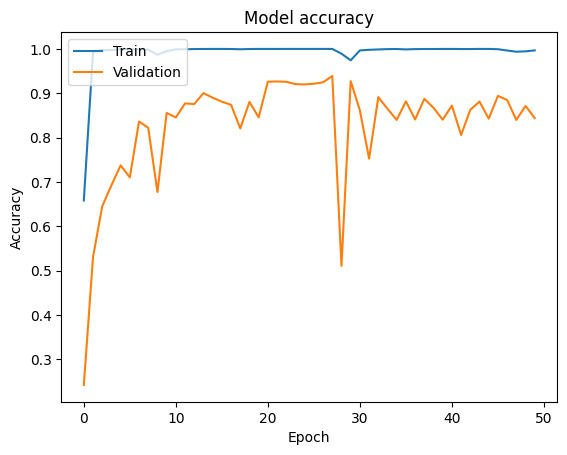

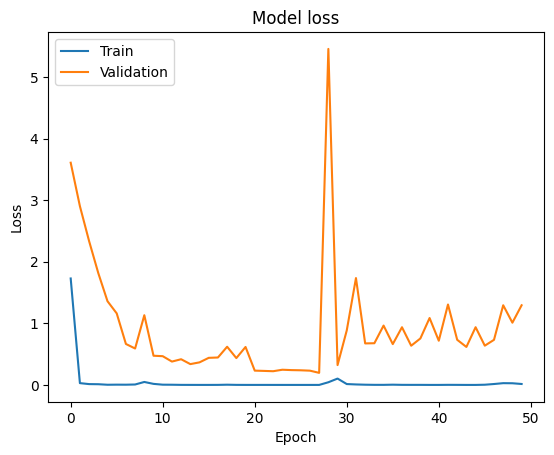

In [12]:
model1_5 = create_model1(0.5)

model1_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1_5.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model1_5.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/50
58/58 [==============================] - 12s 158ms/step - loss: 0.8764 - accuracy: 0.7931 - val_loss: 3.0518 - val_accuracy: 0.2301
Epoch 2/50
58/58 [==============================] - 9s 150ms/step - loss: 0.0216 - accuracy: 0.9949 - val_loss: 1.9770 - val_accuracy: 0.6704
Epoch 3/50
58/58 [==============================] - 9s 150ms/step - loss: 0.0201 - accuracy: 0.9946 - val_loss: 1.0812 - val_accuracy: 0.8928
Epoch 4/50
58/58 [==============================] - 9s 150ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.6406 - val_accuracy: 0.8958
Epoch 5/50
58/58 [==============================] - 9s 149ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.7822 - val_accuracy: 0.8132
Epoch 6/50
58/58 [==============================] - 9s 150ms/step - loss: 0.0522 - accuracy: 0.9864 - val_loss: 1.2849 - val_accuracy: 0.7394
Epoch 7/50
58/58 [==============================] - 9s 149ms/step - loss: 0.0856 - accuracy: 0.9784 - val_loss: 0.2121 - val_accuracy: 0.9397
Epoch

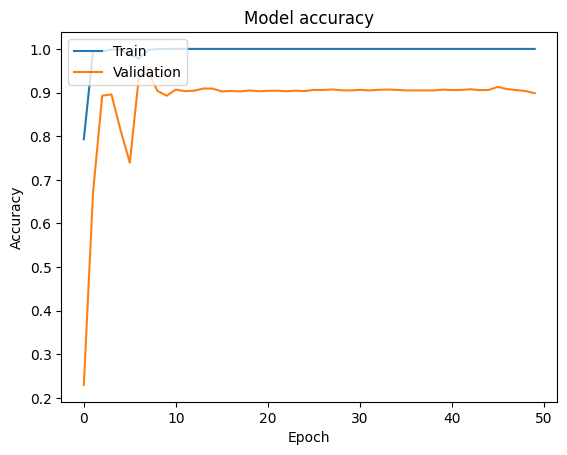

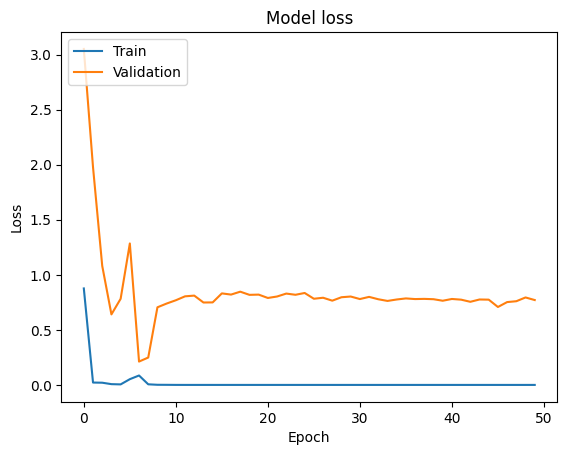

In [13]:
model2 = create_model2(0.3)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model2.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/50
58/58 [==============================] - 17s 258ms/step - loss: 0.9327 - accuracy: 0.7830 - val_loss: 3.0040 - val_accuracy: 0.2124
Epoch 2/50
58/58 [==============================] - 15s 256ms/step - loss: 0.0241 - accuracy: 0.9940 - val_loss: 2.2029 - val_accuracy: 0.3711
Epoch 3/50
58/58 [==============================] - 15s 257ms/step - loss: 0.0047 - accuracy: 0.9994 - val_loss: 0.8390 - val_accuracy: 0.8733
Epoch 4/50
58/58 [==============================] - 15s 257ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.3137 - val_accuracy: 0.9818
Epoch 5/50
58/58 [==============================] - 15s 257ms/step - loss: 8.3476e-04 - accuracy: 1.0000 - val_loss: 0.1522 - val_accuracy: 0.9831
Epoch 6/50
58/58 [==============================] - 15s 257ms/step - loss: 6.0221e-04 - accuracy: 1.0000 - val_loss: 0.0594 - val_accuracy: 0.9910
Epoch 7/50
58/58 [==============================] - 15s 257ms/step - loss: 5.7596e-04 - accuracy: 1.0000 - val_loss: 0.0324 - val_accu

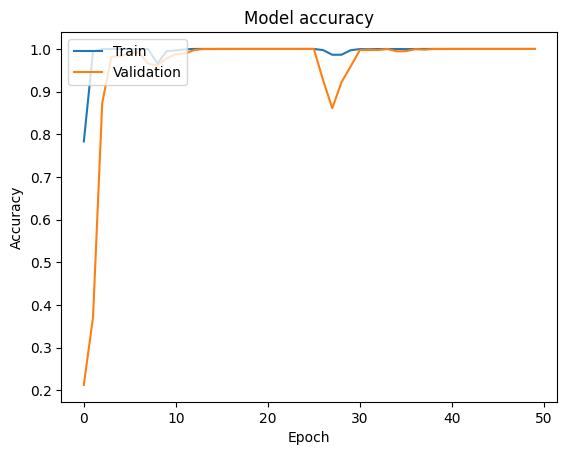

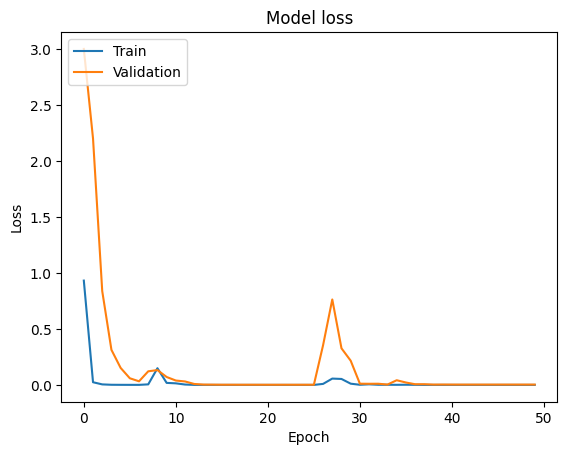

In [17]:
model_bonus = create_model_bonus(0.1)

model_bonus.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_bonus.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
)

test_loss, test_accuracy = model_bonus.evaluate(test_gen)
print(f'Test accuracy: {test_accuracy}')

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Problem 2

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=2000)
word_index = imdb.get_word_index()

# Pad the sequences
x_train = pad_sequences(x_train, maxlen=300)
x_test = pad_sequences(x_test, maxlen=300)


1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=16, input_length=300))
model.add(Conv1D(128, 3, activation='relu', strides=1, padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Split 1000 samples for validation
x_val = x_train[:1000]
y_val = y_train[:1000]
x_train_partial = x_train[1000:]
y_train_partial = y_train[1000:]

history = model.fit(x_train_partial, y_train_partial, epochs=30, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/30
750/750 [==============================] - 19s 24ms/step - loss: 0.4733 - accuracy: 0.7643 - val_loss: 0.3594 - val_accuracy: 0.8380
Epoch 2/30
750/750 [==============================] - 27s 36ms/step - loss: 0.3002 - accuracy: 0.8728 - val_loss: 0.3195 - val_accuracy: 0.8570
Epoch 3/30
750/750 [==============================] - 18s 24ms/step - loss: 0.2496 - accuracy: 0.8965 - val_loss: 0.3036 - val_accuracy: 0.8760
Epoch 4/30
750/750 [==============================] - 17s 22ms/step - loss: 0.2145 - accuracy: 0.9149 - val_loss: 0.3262 - val_accuracy: 0.8670
Epoch 5/30
750/750 [==============================] - 17s 22ms/step - loss: 0.1873 - accuracy: 0.9274 - val_loss: 0.3263 - val_accuracy: 0.8640
Epoch 6/30
750/750 [==============================] - 19s 25ms/step - loss: 0.1637 - accuracy: 0.9388 - val_loss: 0.3399 - val_accuracy: 0.8630
Epoch 7/30
750/750 [==============================] - 16s 22ms/step - loss: 0.1395 - accuracy: 0.9519 - val_loss: 0.3740 - val_accuracy:

In [ ]:
results = model.evaluate(x_test, y_test)
print(f'Test loss: {results[0]}, Test accuracy: {results[1]}')


782/782 [==============================] - 7s 8ms/step - loss: 1.1339 - accuracy: 0.8567
Test loss: 1.1338602304458618, Test accuracy: 0.856719970703125


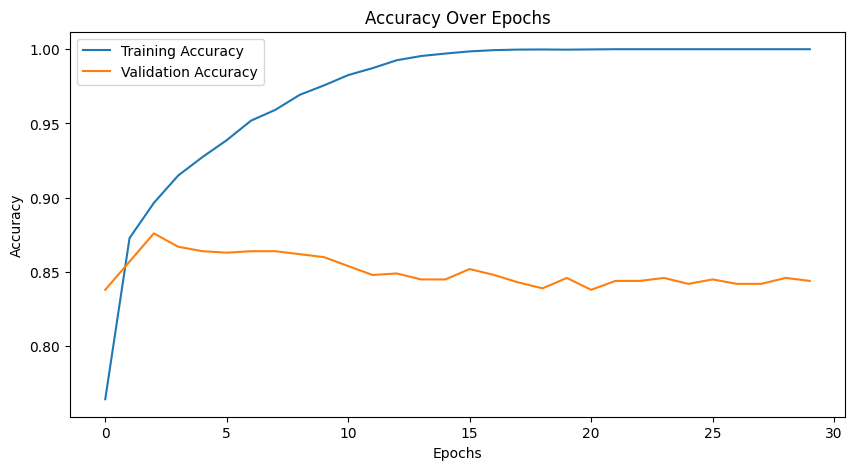

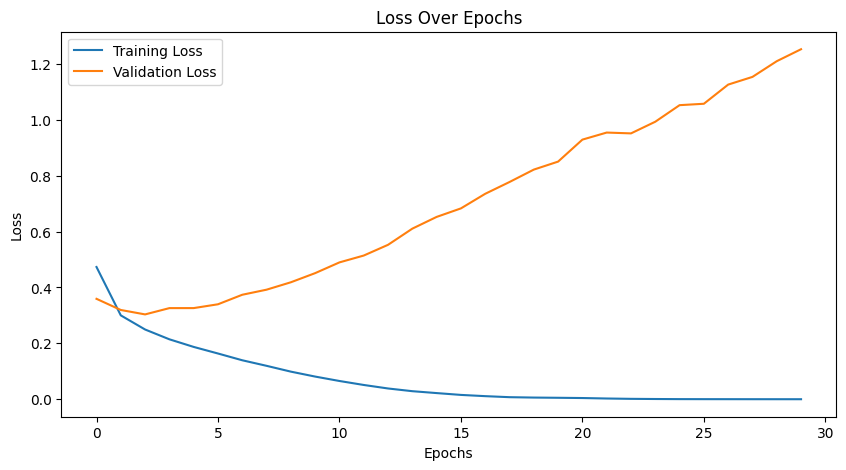

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10,5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=2000, output_dim=16, input_length=300))
model.add(Conv1D(128, 3, activation='relu', strides=1, padding='valid'))
# Add Normalization
model.add(BatchNormalization())
# Add dropout
model.add(Dropout(0.1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # stops after 3 epochs of no improvement

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Split 500 samples for validation
x_val = x_train[:500]
y_val = y_train[:500]
x_train_partial = x_train[500:]
y_train_partial = y_train[500:]

history = model.fit(x_train_partial, y_train_partial, epochs=30, batch_size=4, validation_data=(x_val, y_val), callbacks=[early_stopping])

results = model.evaluate(x_test, y_test)
print(f'Test loss: {results[0]}, Test accuracy: {results[1]}')

import matplotlib.pyplot as plt

history_dict = history.history

# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10,5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()